In [27]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import FeatureExtractor, Classifier, Discriminator
from DA import DenoisingAutoencoder
from test import DANNAccuracy
from train import DANNTrain, DATrain
from visualize import visualize_domain_tSNE, visualize_mnist, visualize_mnistm
from util import generate_domain_datas, generate_domain_datas_from_extractor

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)

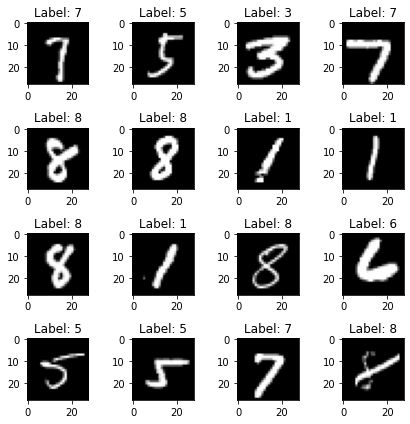

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

C:\Users\15197\Desktop\cs9542_final_project\mnistm_generator.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background = np.random.choice(backgrounds)


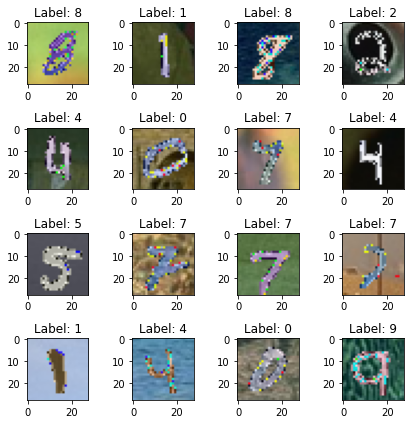

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation

In [ ]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)


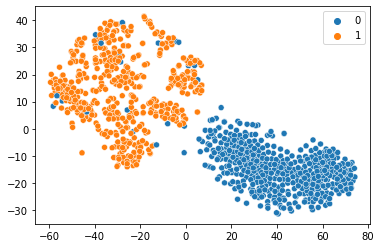

In [117]:

visualize_domain(features, labels, size=1000)

# build DANN model

In [12]:
from train import DANNTrain

source_accs, target_accs, domain_accs, extractor, classifier, discriminator = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=10)

C:\Users\15197\Desktop\cs9542_final_project\mnistm_generator.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background = np.random.choice(backgrounds)


1/10: source_acc: 0.4866666666666667,target_acc: 0.23435, domain_acc: 0.5
2/10: source_acc: 0.5652166666666667,target_acc: 0.23088333333333333, domain_acc: 0.5
3/10: source_acc: 0.6118666666666667,target_acc: 0.24385, domain_acc: 0.5
4/10: source_acc: 0.6732,target_acc: 0.2598666666666667, domain_acc: 0.5
5/10: source_acc: 0.6953833333333334,target_acc: 0.2781666666666667, domain_acc: 0.5
6/10: source_acc: 0.7066833333333333,target_acc: 0.27855, domain_acc: 0.5
7/10: source_acc: 0.7202833333333334,target_acc: 0.2768333333333333, domain_acc: 0.5
8/10: source_acc: 0.7429333333333333,target_acc: 0.27508333333333335, domain_acc: 0.5
9/10: source_acc: 0.7665,target_acc: 0.27613333333333334, domain_acc: 0.5
10/10: source_acc: 0.7858833333333334,target_acc: 0.28021666666666667, domain_acc: 0.5


In [ ]:
plt.plot(source_accs)

In [ ]:
plt.plot(target_accs)

In [ ]:
plt.plot(domain_accs)

# test on test set

In [17]:
DANNAccuracy(extractor, classifier, discriminator, mnist_test_loader, mnistm_test_loader)

(0.7885, 0.2795, 0.5)

# visualize the features after extractor

In [18]:
from util import generate_domain_datas_from_extractor
features, labels = generate_domain_datas_from_extractor(extractor, mnist_train_loader,mnistm_train_loader)

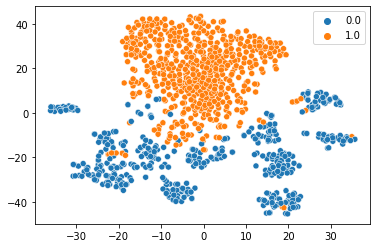

In [19]:
visualize_domain(features, labels,size=1000)

# Autoencoders

In [32]:
def DATrain(mnist_train, mnistm_train, mnist_eval, mnistm_eval, encoded_space_dim, epochs):
    autoencoder = DenoisingAutoencoder(encoded_space_dim).to(device)
    lossf = nn.MSELoss().to(device)
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
    loss_arr = []
    for epoch in range(epochs):
        for batch_idx, (source, target) in enumerate(zip(mnist_train, mnistm_train)):
            source_image, source_label = source
            target_image, target_label = target

                # the source is 1 * 28 * 28, we have to preprocess it
            source_image = torch.cat((source_image, source_image, source_image),1)
            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)
            total_image = torch.cat((source_image, target_image), 0)

            # clear the grad
            optimizer.zero_grad()

            reconstructed = autoencoder(total_image)

            loss = lossf(reconstructed, total_image)
            loss.backward()
            optimizer.step()
        
        total_loss = 0
        with torch.no_grad():
            
            for batch_idx, (source, target) in enumerate(zip(mnist_eval, mnistm_eval)):
                source_image, source_label = source
                target_image, target_label = target

                source_image = torch.cat((source_image, source_image, source_image),1)

                source_image, source_label = source_image.to(device), source_label.to(device)
                target_image, target_label = target_image.to(device), target_label.to(device)
                total_image = torch.cat((source_image, target_image), 0)


                reconstructed = autoencoder(total_image)
                loss = lossf(reconstructed, total_image)
                total_loss += loss
            loss_arr.append(total_loss.cpu()/len(mnist_eval))
            print(f'{epoch+1}/{epochs}: avg_loss:{total_loss/len(mnist_eval)}')
        scheduler.step(total_loss/len(mnist_eval))
    return loss_arr, autoencoder

In [33]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,100,100)

1/100: avg_loss:0.12166392058134079
2/100: avg_loss:0.10937384516000748
3/100: avg_loss:0.10375405102968216
4/100: avg_loss:0.09754928946495056
5/100: avg_loss:0.08955363184213638
6/100: avg_loss:0.08228108286857605
7/100: avg_loss:0.07743344455957413
8/100: avg_loss:0.07355727255344391
9/100: avg_loss:0.07067376375198364
10/100: avg_loss:0.06794571131467819
11/100: avg_loss:0.06557424366474152
12/100: avg_loss:0.0634247288107872
13/100: avg_loss:0.06156178191304207
14/100: avg_loss:0.05976679548621178
15/100: avg_loss:0.05798105522990227
16/100: avg_loss:0.05654970556497574
17/100: avg_loss:0.05491241067647934
18/100: avg_loss:0.05339820310473442
19/100: avg_loss:0.05180136114358902
20/100: avg_loss:0.05032802373170853
21/100: avg_loss:0.04886462911963463
22/100: avg_loss:0.04748038202524185
23/100: avg_loss:0.04603930190205574
24/100: avg_loss:0.04472525790333748
25/100: avg_loss:0.04353377968072891
26/100: avg_loss:0.04247663915157318
27/100: avg_loss:0.04128999635577202
28/100: avg

In [34]:
    
def visualize_mnist_from_DA(loader,size):
    temp_iter = iter(loader)
    temp_features, temp_labels = temp_iter.next()
    temp_features = torch.cat((temp_features,temp_features,temp_features),1)
    compressed_features = autoencoder(temp_features.to(device)).cpu().detach()
    fig, axes = plt.subplots(size,size, figsize=(1.5*size,1.5*size))
    for i in range(size):
        for j in range(size):
            axes[i,j].imshow(compressed_features[i*4+j].transpose(0,2).transpose(0,1))
            axes[i,j].set_title(f"Label: {temp_labels[i*4+j]}")
    plt.tight_layout()
    plt.show()

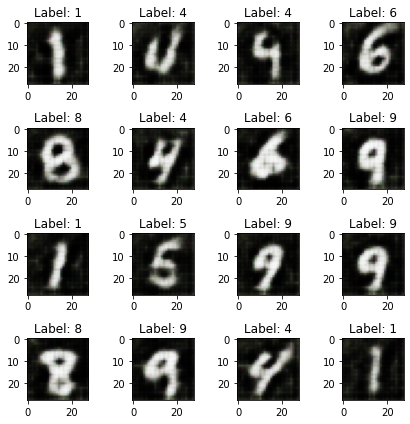

In [35]:
visualize_mnist_from_DA(mnist_train_loader,4)

In [36]:
def visualize_mnistm_from_DA(loader,size):
    temp_iter = iter(loader)
    temp_features, temp_labels = temp_iter.next()
    compressed_features = autoencoder(temp_features.to(device)).cpu().detach()
    fig, axes = plt.subplots(size,size, figsize=(1.5*size,1.5*size))
    for i in range(size):
        for j in range(size):
            axes[i,j].imshow(compressed_features[i*4+j].transpose(0,2).transpose(0,1))
            axes[i,j].set_title(f"Label: {temp_labels[i*4+j]}")
    plt.tight_layout()
    plt.show()

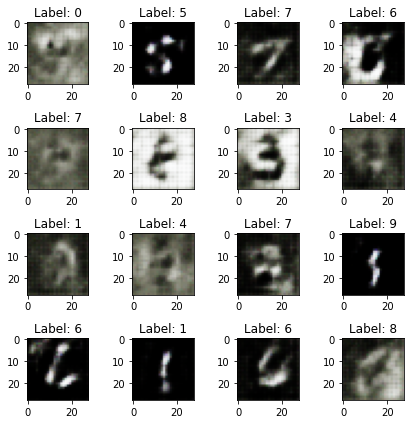

In [37]:
visualize_mnistm_from_DA(mnistm_train_loader,4)